### DeepFake Image Detection using CNN-SVM

###### Import Python Libraries

In [ ]:
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np# Keras API_
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**Load Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###### Load training, testing and validation samples

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/DeepFake_CNN_SVM/Deep_Fake_Train"
test_path = "/content/drive/MyDrive/Colab Notebooks/DeepFake_CNN_SVM/Deep_Fake_Test"
#val_path = "/content/drive/MyDrive/Colab Notebooks/DeepFake_CNN_SVM/DeepFake_Validation"

##### Get number of images in the path

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0

  for current_path, dirs, files in os.walk(directory):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path, dr +"/*")))
  return count

In [ ]:
num_classes = len(glob.glob(train_path + "/*"))
train_samples = get_files(train_path)
test_samples = get_files(test_path)
#val_samples = get_files(val_path)

print(num_classes, "Classes")
print(train_samples, "Train images")
print(test_samples, "Test images")
#print(val_samples, "Validation images")

2 Classes
4000 Train images
1000 Test images


##### Image Pre-processing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

#val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_width, img_height = 150, 150
batch_size = 32

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size = (img_width, img_height),
                                                   batch_size = batch_size)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  shuffle = False,
                                                  target_size = (img_width, img_height),
                                                  batch_size = batch_size)

#val_generator = val_datagen.flow_from_directory(val_path,
                                                  #shuffle = False,
                                                  #target_size = (img_width, img_height),
                                                  #batch_size = batch_size)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Get Classes and Labels

In [ ]:
classes = train_generator.class_indices

In [ ]:
classes

{'Fake': 0, 'Real': 1}

In [ ]:
labels = ['Fake','Real']

In [ ]:
labels

['Fake', 'Real']

***Build CNN Parameters***

In [ ]:
input_shape = (img_width, img_height, 3)
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model with the specified optimizer, loss, and metrics
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True)

model_checkpoint = ModelCheckpoint(
    'experiment_best_deepFake_model.h5',
    monitor = 'val_accuracy',
    save_best_only = True)

# Train the model with the specified callbacks
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = test_generator,
    validation_steps = len(test_generator),
    verbose = 1,
    epochs = 50,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
125/125 [==============================] - 1858s 15s/step - loss: 0.6461 - accuracy: 0.6248 - val_loss: 1.0589 - val_accuracy: 0.5510


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
125/125 [==============================] - 34s 276ms/step - loss: 0.5792 - accuracy: 0.7080 - val_loss: 0.7704 - val_accuracy: 0.5480
Epoch 3/50
125/125 [==============================] - 35s 277ms/step - loss: 0.5111 - accuracy: 0.7623 - val_loss: 0.7373 - val_accuracy: 0.5870
Epoch 4/50
125/125 [==============================] - 34s 275ms/step - loss: 0.4650 - accuracy: 0.7855 - val_loss: 0.6447 - val_accuracy: 0.6480
Epoch 5/50
125/125 [==============================] - 35s 281ms/step - loss: 0.4286 - accuracy: 0.8012 - val_loss: 0.6704 - val_accuracy: 0.6450
Epoch 6/50
125/125 [==============================] - 35s 279ms/step - loss: 0.4336 - accuracy: 0.8025 - val_loss: 0.6537 - val_accuracy: 0.6450
Epoch 7/50
125/125 [==============================] - 35s 281ms/step - loss: 0.4100 - accuracy: 0.8220 - val_loss: 0.6532 - val_accuracy: 0.6550
Epoch 8/50
125/125 [==============================] - 35s 281ms/step - loss: 0.3824 - accuracy: 0.8347 - val_loss: 0.6385 - val_ac

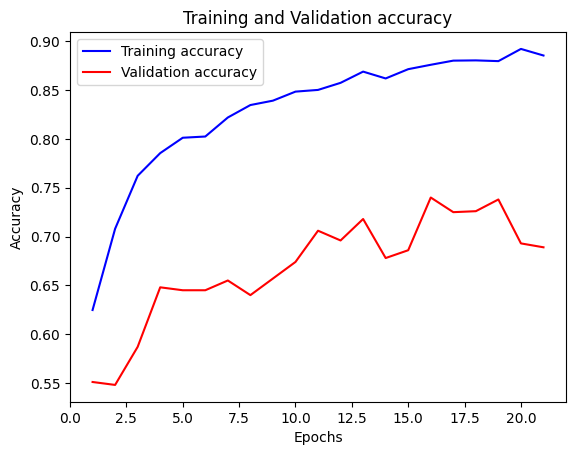

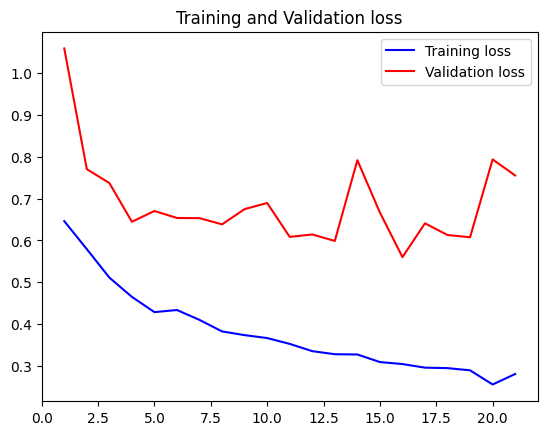

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model from the ModelCheckpoint
from tensorflow.keras.models import load_model
best_model = load_model('/content/experiment_best_deepFake_model.h5')

In [ ]:
# Extract features from the training and validation sets
X_train_features = best_model.predict(train_generator)
X_val_features = best_model.predict(test_generator)

32/32 [==============================] - 3s 77ms/step


In [ ]:
from sklearn import svm
# Create the SVM model with RBF kernel and specified C and gamma
svm_model = svm.SVC(kernel = 'rbf', C = 100, gamma = 0.01)

In [ ]:
# Train the SVM classifier
svm_model.fit(X_train_features, train_generator.classes)

SVC(C=100, gamma=0.01)

In [ ]:
# Predict on the test set
predictions = svm_model.predict(X_val_features)

# Evaluate the accuracy
accuracy = accuracy_score(test_generator.classes, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 73.90%


In [ ]:
print(predictions)

[1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1
 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1
 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0
 0 0 0 1 1 1 1 0 1 0 0 0 

In [ ]:
# Print Classification Report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(test_generator.classes, predictions, target_names = labels))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.77      0.70      0.73       500
        Real       0.72      0.79      0.75       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



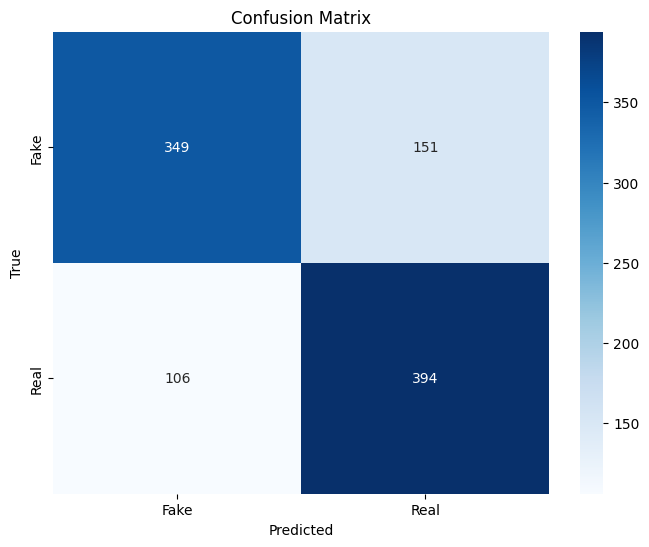

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()